## __Toronto Data Science Capstone Project__

#### I'm a new business owner and I'm looking to open a new dog grooming business. Which neighborhood should I open my business in if I want to make sure I will have foot traffic?

Ideally, I would like to be close to parks, restaurants and dog runs. 

In [1]:
#Import libraries and define webpage for scraping
import numpy as np

import lxml.html as lh
import requests
import pandas as pd 

url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = requests.get(url)
#Store the contents of the website under doc
doc = lh.fromstring(page.content)
#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')

In [2]:
tr_elements = doc.xpath('//tr')
#Create empty list
col=[]
i=0
#For each row, store each first element (header) and an empty list
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    print('%d:"%s"'%(i,name))
    col.append((name,[]))

1:"Postcode"
2:"Borough"
3:"Neighbourhood
"


Loop through table to create dataframe

In [3]:

#Since out first row is the header, data is stored on the second row onwards
for j in range(1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row is not of size 3, the //tr data is not from our table 
    if len(T)!=3:
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content() 
        #Check if row is empty
        if i>0:
        #Convert any numerical value to integers
            try:
                data=int(data)
            except:
                pass
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1
Dict={title:column for (title,column) in col}
df=pd.DataFrame(Dict)

In [4]:
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned\n
1,M2A,Not assigned,Not assigned\n
2,M3A,North York,Parkwoods\n
3,M4A,North York,Victoria Village\n
4,M5A,Downtown Toronto,Harbourfront\n


Format dataframe

In [5]:
df.rename(columns ={'Neighbourhood\n':'Neighborhood','Postcode':'PostalCode'
                          }, 
                 inplace=True)
df.drop(df[df['Borough'] == 'Not assigned'].index, inplace=True)

In [6]:
df['Neighborhood']=df['Neighborhood'].str.replace("\n", "")

In [7]:
df_1 = df.groupby(['PostalCode', 'Borough'])['Neighborhood'].apply(', '.join).reset_index()

Read in coordinates csv and join to toronto dataframe

In [8]:
coord = pd.read_csv('Geospatial_Coordinates.csv')
coord.rename(columns ={'Postal Code':'PostalCode'
                          }, 
                 inplace=True)

In [9]:
df = pd.merge(df_1, coord, on='PostalCode')

In [10]:
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [14]:
df['Borough'].unique()
toronto_boroughs = ['East Toronto', 'Central Toronto', 'Downtown Toronto', 'West Toronto']
central_df = df[df['Borough'].isin(toronto_boroughs)].reset_index(drop=True)
print(central_df.shape)
central_df.head()

(38, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [15]:
import json 

In [16]:

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans
import folium # map rendering library
import geopy

In [17]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [18]:
print("The geograpical coordinate of Toronto are {}, {}".format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207


In [19]:

CLIENT_ID = 'EJF2T3C2DPZ4SXFOBWV1RMCYIEEDT13KS3R213TGTZ1ELUCS' # your Foursquare ID
CLIENT_SECRET = 'OIGCO5H2A0W44AUJJDAGP2CM34LWGQZ2OPKQ3CPHLJTCDFI2' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [20]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [21]:
toronto_venues = getNearbyVenues(names=central_df['Neighborhood'],
                                   latitudes=central_df['Latitude'],
                                   longitudes=central_df['Longitude']
                                  )



The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The 

In [22]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 
Neighborhood = toronto_onehot['Neighborhood']
# move neighborhood column to the first column
toronto_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
toronto_onehot.insert(0, 'Neighborhood', Neighborhood)


toronto_onehot.head()

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"The Danforth West, Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [25]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Bar,Steakhouse,Burger Joint,Restaurant,Cosmetics Shop,American Restaurant,Thai Restaurant,Hotel
1,Berczy Park,Coffee Shop,Cocktail Bar,Farmers Market,Seafood Restaurant,Bakery,Café,Steakhouse,Cheese Shop,Beer Bar,Jazz Club
2,"Brockton, Exhibition Place, Parkdale Village",Coffee Shop,Breakfast Spot,Café,Performing Arts Venue,Yoga Studio,Stadium,Burrito Place,Caribbean Restaurant,Restaurant,Climbing Gym
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Yoga Studio,Auto Workshop,Garden Center,Garden,Fast Food Restaurant,Farmers Market,Comic Shop,Park,Recording Studio
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Lounge,Airport Terminal,Boutique,Coffee Shop,Airport,Airport Food Court,Airport Gate,Airport Service,Harbor / Marina,Sculpture Garden


In [32]:
toronto_grouped_clustering = toronto_grouped.drop(['Neighborhood'], axis =1)

Cluster neighborhoods by common venues 

In [34]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
mms.fit(toronto_grouped_clustering)
data_transformed = mms.transform(toronto_grouped_clustering)

Normalize data and use the elbow method to determine number of clusters 

In [35]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

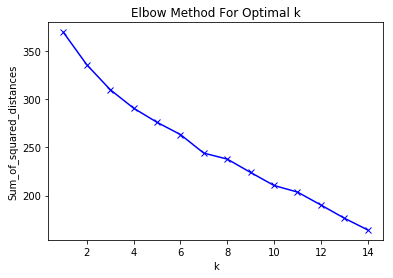

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The best number of clusters to use is 6

In [83]:
kclusters = 6

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

add the clustered labels to the dataset

In [84]:


toronto_clustered_df = central_df
toronto_clustered_df['Cluster'] = kmeans.labels_
toronto_clustered_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,1
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,1
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,1
3,M4M,East Toronto,Studio District,43.659526,-79.340923,1
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,1


In [86]:
toronto_merged = toronto_clustered_df

toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')


In [87]:
toronto_merged = toronto_merged.drop('Cluster', 1)

In [88]:
toronto_merged['3rd Most Common Venue'].unique()

array(['Trail', 'Italian Restaurant', 'Sushi Restaurant', 'Bakery',
       'Bus Line', 'Grocery Store', 'Clothing Store', 'Gym', 'Restaurant',
       'American Restaurant', 'Coffee Shop', 'Gay Bar', 'Cosmetics Shop',
       'Hotel', 'Farmers Market', 'Sandwich Place', 'Bar', 'Music Venue',
       'Jewelry Store', 'Chinese Restaurant', 'Boutique', 'Café', 'Park',
       'Asian Restaurant', 'Dessert Shop', 'Auto Workshop'], dtype=object)

Map the Clusters using folium 

In [52]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [91]:
toronto_filtered = toronto_merged[(toronto_merged['1st Most Common Venue'] =='Park') | (toronto_merged['2nd Most Common Venue'] =='Restaurant')]

In [92]:
toronto_filtered

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,0,Park,Sandwich Place,Sushi Restaurant,Pet Store,Pizza Place,Movie Theater,Pub,Burrito Place,Burger Joint,Brewery
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,1,Park,Swim School,Bus Line,Yoga Studio,Dog Run,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
10,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,2,Park,Playground,Trail,Building,Discount Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
11,M4X,Downtown Toronto,"Cabbagetown, St. James Town",43.667967,-79.367675,0,Park,Restaurant,Coffee Shop,Bakery,Pub,Italian Restaurant,Pizza Place,Café,American Restaurant,Grocery Store
23,M5P,Central Toronto,"Forest Hill North, Forest Hill West",43.696948,-79.411307,6,Park,Trail,Jewelry Store,Sushi Restaurant,Yoga Studio,Dog Run,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
28,M5W,Downtown Toronto,Stn A PO Boxes 25 The Esplanade,43.646435,-79.374846,0,Coffee Shop,Restaurant,Café,Hotel,Beer Bar,Cocktail Bar,Italian Restaurant,Seafood Restaurant,Cheese Shop,Japanese Restaurant


If we are to assume most dog owners would like to live close to a park, restaurants, and dog runs, 
the best place to open a dog grooming shop would be Lawrence Park or Forest Hill. 